In [2]:
import os
os.chdir('../')

In [49]:
import pandas as pd
from pathlib import Path
from ast import literal_eval
import numpy as np
import wrds
pd.set_option('display.max_columns', None)
from rapidfuzz import fuzz
import re
from source.scrape.get_linkedin_profiles.docs.get_linkedin_profiles import *
from joblib import Parallel, delayed
from datetime import datetime

In [4]:
indir_locations = Path("drive/output/scrape/get_standardized_locations")
indir_profiles = Path('drive/output/scrape/get_linkedin_profiles')
indir_departures = Path('drive/output/derived/contributor_stats/departed_contributors')

In [5]:
df_all_departures = AggregateAllDepartures(indir_departures)

In [6]:
github_profile_locations = pd.read_csv(indir_locations / "standardized_locations_github.csv", index_col = 0)
linkedin_profile_locations = pd.read_csv(indir_locations / "standardized_locations_linkedin.csv", index_col = 0)

departed_committers = pd.read_csv(indir_profiles / 'departed_github_profiles.csv', index_col = 0)
departed_linkedin_profiles = pd.read_parquet(indir_profiles / 'departed_linkedin_profiles.parquet')
departed_linkedin_positions = pd.read_parquet(indir_profiles / 'departed_linkedin_positions.parquet')

In [7]:
departed_committers_clean = departed_committers[['repo_name','actor_id','name_clean','linkedin_url','company','location']]
departed_committers_clean['name_clean'] = departed_committers_clean['name_clean'].replace('[nan]',np.nan)
departed_committers_clean['name_clean'] = departed_committers_clean['name_clean'].apply(lambda x: literal_eval(x) if not pd.isnull(x) else x)

/tmp/user/20506/ipykernel_561841/1377185294.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  departed_committers_clean['name_clean'] = departed_committers_clean['name_clean'].replace('[nan]',np.nan)
/tmp/user/20506/ipykernel_561841/1377185294.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  departed_committers_clean['name_clean'] = departed_committers_clean['name_clean'].apply(lambda x: literal_eval(x) if not pd.isnull(x) else x)


In [8]:
for col in ['standardized_location_address', 'standardized_location_raw']:
    github_profile_locations[col] = github_profile_locations[col].apply(lambda x: literal_eval(x) if not pd.isnull(x) else x)
    linkedin_profile_locations[col] = linkedin_profile_locations[col].apply(lambda x: literal_eval(x) if not pd.isnull(x) else x)

In [9]:
departed_committers_location = pd.merge(departed_committers_clean, github_profile_locations.drop('standardized_location', axis = 1))
departed_committers_location.reset_index(inplace = True)
departed_committers_location['fullname'] = departed_committers_location['name_clean']
departed_committers_location = departed_committers_location.explode('fullname')
departed_profiles_location = pd.merge(departed_linkedin_profiles, linkedin_profile_locations.drop('standardized_location', axis = 1), how = 'left')

In [10]:
departed_profiles_location_merge = departed_profiles_location.rename({'standardized_location_address':'standardized_linkedin_address', 'standardized_location_raw':'raw_linkedin_address'}, axis = 1)\
    [['user_id','fullname','standardized_linkedin_address','raw_linkedin_address','profile_linkedin_url']]

In [11]:
# first, see if there's an exact location match
print("{} unique committers to start with".format(departed_committers_location['index'].unique().shape[0]))
merged_committers = pd.merge(departed_committers_location, departed_profiles_location_merge, on = 'fullname')
print("{} unique committers can be matched to linkedin profiles".format(merged_committers['index'].unique().shape[0]))
merged_committers['location_intersection'] = merged_committers.apply(lambda x: set(x['standardized_location_address']).intersection(x['standardized_linkedin_address']) if type(x['standardized_location_address']) == list
                                                                     and type(x['standardized_linkedin_address']) == list else [], axis = 1)
merged_committers = merged_committers[merged_committers.apply(lambda x: type(x['standardized_location_address']) == list and type(x['standardized_linkedin_address']) == list or
                                                              not pd.isnull(x['company']), axis = 1)]
print("{} unique committers have GH and linkedin locations, or a GH company name".format(merged_committers['index'].unique().shape[0]))
merged_committers['exact_match'] = merged_committers.assign(location_intersection_length = merged_committers['location_intersection'].apply(lambda x: len(x)>0)).groupby(['repo_name','actor_id'])['location_intersection_length']\
    .transform('any')

13502 unique committers to start with
7115 unique committers can be matched to linkedin profiles
5742 unique committers have GH and linkedin locations, or a GH company name


In [12]:
# next, filter out different countries and states
merged_committers['github_country'] = merged_committers['standardized_location_raw'].apply(
    lambda x: set(list([country['address_components'][-1]['long_name'] for country in x])) if type(x) != float else set())
merged_committers['github_state'] = merged_committers['standardized_location_raw'].apply(
    lambda x: set(list([country['address_components'][-2]['long_name'] for country in x if len(country['address_components'])>1])) if type(x) != float else set())
merged_committers['linkedin_country'] = merged_committers['raw_linkedin_address'].apply(
    lambda x: set(list([country['address_components'][-1]['long_name'] for country in x])) if type(x) != float else set())
merged_committers['linkedin_state'] = merged_committers['raw_linkedin_address'].apply(
    lambda x: set(list([country['address_components'][-2]['long_name'] for country in x if len(country['address_components'])>1])) if type(x) != float else set())
for region in ['country','state']:
    merged_committers[f'{region}_overlap'] = merged_committers.apply(lambda x: x[f'github_{region}'].intersection(x[f'linkedin_{region}']), axis = 1)
merged_committers = merged_committers[merged_committers.apply(lambda x: (len(x['country_overlap'])>0 and len(x['state_overlap'])>0) or x['exact_match'] or
                                                              (not pd.isnull(x['company']) and type(x['standardized_location_address']) == float or type(x['standardized_linkedin_address']) == float), axis = 1)]
print("{} unique committers have a potential location match or a GH company name".format(merged_committers['index'].unique().shape[0]))

4396 unique committers have a potential location match or a GH company name


In [13]:
# if a perfect match exists, filter out non perfect matches
merged_committers = merged_committers[merged_committers.apply(lambda x: not (x['exact_match'] and len(x['location_intersection'])==0), axis = 1)]
departed_positions = departed_linkedin_positions[departed_linkedin_positions['user_id'].isin(merged_committers['user_id'].tolist())]

In [14]:
params = dict()
company_list = tuple(departed_positions['rcid'].dropna().drop_duplicates().tolist())
params['company_list'] = company_list

db = wrds.Connection(wrds_username="chrisliao")
company_mappings = db.raw_sql("""SELECT * FROM revelio.company_mapping WHERE rcid in %(company_list)s""", params = params)
db.close()

Loading library list...
Done


In [15]:
departed_company_mappings = pd.merge(departed_positions, company_mappings[['rcid','company','ultimate_parent_company_name']])[['user_id','company','ultimate_parent_company_name']].drop_duplicates()\
    .rename({'company':'linkedin_company_name'}, axis = 1)
company_list = departed_company_mappings.groupby('user_id').agg({'linkedin_company_name':list, 'ultimate_parent_company_name':list}).reset_index()
merged_committers['merge_count'] = merged_committers.groupby(['repo_name','actor_id'])['name_clean'].transform('count')
merged_committers = pd.merge(merged_committers, company_list, how = 'left')
# filter out those we can't match by company (linkedin, github)
merged_committers = merged_committers[merged_committers.apply(lambda x:  not (x['merge_count']>1 and type(x['linkedin_company_name']) == float or pd.isnull(x['company'])), axis = 1)]
print("{} unique committers have a potential location match or a potential GH company match".format(merged_committers['index'].unique().shape[0]))

3154 unique committers have a potential location match or a potential GH company match


In [16]:
merged_committers['linkedin_company_matches'] = merged_committers.apply(
    lambda x: [(comp_name, round(fuzz.ratio(x['company'].lower(), comp_name.lower()), 2)) for comp_name in x['linkedin_company_name']] 
    if type(x['linkedin_company_name']) == list and not pd.isnull(x['company']) else np.nan, axis = 1)

In [17]:
merged_committers['company_match'] = merged_committers['linkedin_company_matches'].apply(lambda x: any([score[1]>45 for score in x]) if type(x) == list else False)
merged_committers['max_score'] = merged_committers['linkedin_company_matches'].apply(lambda x: max([score[1] for score in x]) if type(x) == list else np.nan)
merged_committers = merged_committers.query('company_match | max_score.isna()')
merged_committers['merge_count'] = merged_committers.groupby(['repo_name','actor_id'])['name_clean'].transform('count')
merged_committers = pd.merge(merged_committers, departed_linkedin_profiles[['user_id','updated_dt']])
print("{} unique committers have a potential location match & a potential GH company match".format(merged_committers['index'].unique().shape[0]))

1975 unique committers have a potential location match & a potential GH company match


In [18]:
merged_committers = merged_committers.sort_values(['max_score','updated_dt'], ascending = False).drop_duplicates(['repo_name','actor_id'])
merged_committers = merged_committers.drop(['name_clean','linkedin_url','index'], axis = 1)

In [19]:
departed_committers_linkedin = pd.merge(departed_committers_clean, merged_committers, how = 'left')[['repo_name','actor_id','linkedin_url','profile_linkedin_url','user_id']]
departed_committers_linkedin['linkedin_url'] = departed_committers_linkedin.apply(
    lambda x: x['linkedin_url'] if not pd.isnull(x['linkedin_url']) else x['profile_linkedin_url'], axis = 1)
departed_committers_linkedin.drop('profile_linkedin_url', axis = 1, inplace = True)

In [20]:
pattern = r'^(?:https?:\/\/)?(?:www\.)?linkedin\.com/(.*)$'
departed_committers_linkedin['linkedin_url'] = departed_committers_linkedin['linkedin_url'].apply(lambda x: re.sub(pattern, r'linkedin.com/\1', x) if not pd.isnull(x) else x)

In [21]:
params = dict()
linkedin_profiles = tuple(departed_committers_linkedin.query('~linkedin_url.isna() & user_id.isna()')['linkedin_url'].tolist())
params['linkedin_profiles'] = linkedin_profiles

db = wrds.Connection(wrds_username="chrisliao")
github_linkedin_profiles = db.raw_sql("""SELECT * FROM revelio.individual_user WHERE profile_linkedin_url in %(linkedin_profiles)s""", params = params)
db.close()

Loading library list...
Done


In [22]:
profile_user_dict = github_linkedin_profiles[['profile_linkedin_url','user_id']].set_index('profile_linkedin_url').to_dict()['user_id']
departed_committers_linkedin['user_id'] = departed_committers_linkedin.apply(lambda x: profile_user_dict.get(x['linkedin_url'], x['user_id']), axis = 1)

In [23]:
db = wrds.Connection(wrds_username="chrisliao")
departed_linkedin_profiles_all = QueryForLinkedinPositions(departed_committers_linkedin.dropna(), db)

Loading library list...
Done


In [24]:
# 1. get positions for relevant users
# 2. see if in the hypothesized departure period, they changed jobs
#departed_linkedin_profiles_all.groupby('user_id')['
for datecol in ['startdate','enddate']:
    departed_linkedin_profiles_all[datecol] = pd.to_datetime(departed_linkedin_profiles_all[datecol])
departed_job_change_dates = departed_linkedin_profiles_all.groupby('user_id').agg({'startdate':list, 'enddate':list}).reset_index()
for datecol in ['startdate','enddate']:
    departed_job_change_dates[datecol] = departed_job_change_dates[datecol].apply(lambda x: list(set([ele.date() for ele in x if not pd.isnull(ele)])))

In [25]:
departed_full = pd.merge(departed_committers_linkedin, departed_job_change_dates, how = 'left')
for datecol in ['startdate','enddate']:
    departed_full[datecol] = departed_full[datecol].apply(lambda x: np.nan if type(x) == list and len(x) == 0 else x)

In [53]:
def SummarizeSpecification(df_specification, idx, time_period, rolling_window, departed_full, indir_departures):
    criteria_pct = df_specifications.loc[idx,'criteria_pct']
    consecutive_periods = df_specifications.loc[idx,'consecutive_periods']
    post_period_length = df_specifications.loc[idx,'post_period_length']
    decline_type = df_specifications.loc[idx,'decline_type']
    decline_stat = df_specifications.loc[idx,'decline_stat']
    if decline_stat == 0 or decline_type == "threshold_gap_qty":
        decline_stat = int(decline_stat)
    
    df_departed = pd.read_parquet(indir_departures / f'departed_contributors_major_months{time_period}_window{rolling_window}D_criteria_commits_{criteria_pct}pct_consecutive{consecutive_periods}_post_period{post_period_length}_{decline_type}_{decline_stat}.parquet')
    df_departure_range = CleanDepartures(df_departed, decline_type)
    df_departure_range = pd.merge(df_departure_range, departed_full, how = 'left')
    df_departure_range['startdate_dep'] = df_departure_range.apply(
        lambda x: any([x['time_range'][0] <= ele <= x['time_range'][1] for ele in x['startdate']]) if type(x['startdate']) == list else False, axis = 1)
    df_departure_range['enddate_dep'] = df_departure_range.apply(
        lambda x: any([x['time_range'][0] <= ele <= x['time_range'][1] for ele in x['enddate']]) if type(x['enddate']) == list else False, axis = 1)
    df_departure_range['corresponding_departure'] = df_departure_range.apply(
        lambda x: x['startdate_dep'] or x['enddate_dep'], axis = 1)
    departure_count = df_departure_range.shape[0]
    linkedin_match_pct = 1-df_departure_range['user_id'].isna().mean()
    departure_occurred_pct = df_departure_range.query('~user_id.isna()')['corresponding_departure'].mean()
    
    return [time_period, rolling_window, 'commits', criteria_pct, consecutive_periods, post_period_length, decline_type, decline_stat,\
            departure_count, linkedin_match_pct, departure_occurred_pct]

def CleanDepartures(df_departed, decline_type):
    if decline_type == "threshold_gap_qty":
        df_departed = df_departed.query('below_qty_mean_gap0 == 1 | below_qty_mean_gap1 == 1')

    df_departed = pd.merge(df_departed, df_departed.query('time_period == final_period')\
                           [['repo_name','actor_id','grouped_index']].rename({'grouped_index':'final_index'}, axis = 1))
    if decline_type == "threshold_gap_qty":
        df_departed['final_index'] = df_departed.apply(
            lambda x: x['final_index'] if x['below_qty_mean_gap0'] == 1 else x['final_index']+1, axis = 1)
    df_departed = pd.merge(df_departed.drop('final_period', axis = 1), df_departed.query('grouped_index == final_index')[['actor_id','repo_name','time_period']]\
                          .rename({'time_period':'final_period'}, axis = 1))
    df_departed['first_post_period_index'] = df_departed['final_index'] + 1
    df_departed['relative_time'] = (df_departed['grouped_index'] - df_departed['final_index'])-1

        
    df_departed['time_period'] = pd.to_datetime(df_departed['time_period'])
    df_departure_range = df_departed.query('relative_time == -1 | relative_time == 0')\
        .groupby(['repo_name','actor_id']).agg({'time_period':list}).reset_index()
    df_departure_range['time_range'] = df_departure_range['time_period'].apply(lambda x: [x[0].date(), x[1].date()])
    df_departure_range = df_departure_range[df_departure_range['time_range'].apply(lambda x: x[0]<datetime(2023, 1, 1).date())]
    
    return df_departure_range.drop('time_period', axis = 1)

In [54]:
%%time
departure_validation_cols = ['time_period','rolling_window','criteria_col','criteria_pct','consecutive_periods',
                             'post_period_length','decline_type','decline_stat', 'departure_count', 'linkedin_match_pct', 'departure_occurred_pct']
df_departure_linkedin_validation = pd.DataFrame(columns = departure_validation_cols)
for time_period in [6]:
    for rolling_window in [732, 1828]:
        print(time_period, rolling_window)
        df_specifications = pd.read_csv(indir_departures / f'departed_contributors_specification_summary_major_months{time_period}_window{rolling_window}D.csv').query('criteria_col == "commits"')
        results = [SummarizeSpecification(df_specifications, idx, time_period, rolling_window, departed_full, indir_departures) for idx in df_specifications.index]
        tmp_df = pd.DataFrame(results, columns=departure_validation_cols)
        df_departure_linkedin_validation = pd.concat(
            [df_departure_linkedin_validation, tmp_df],
            ignore_index=True
        )

6 732


<timed exec>:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


6 1828
CPU times: user 32.9 s, sys: 987 ms, total: 33.9 s
Wall time: 30.6 s


In [56]:
criteria_pct = 75
consecutive_periods = 3
post_period_length = 2
decline_type = 'threshold_gap_qty'
decline_stat = 0
if decline_stat == 0 or decline_type == "threshold_gap_qty":
    decline_stat = int(decline_stat)

df_departed = pd.read_parquet(indir_departures / f'departed_contributors_major_months{time_period}_window{rolling_window}D_criteria_commits_{criteria_pct}pct_consecutive{consecutive_periods}_post_period{post_period_length}_{decline_type}_{decline_stat}.parquet')
df_departure_range = CleanDepartures(df_departed, decline_type)
df_departure_range = pd.merge(df_departure_range, departed_full, how = 'left')
df_departure_range['startdate_dep'] = df_departure_range.apply(
    lambda x: any([x['time_range'][0] <= ele <= x['time_range'][1] for ele in x['startdate']]) if type(x['startdate']) == list else False, axis = 1)
df_departure_range['enddate_dep'] = df_departure_range.apply(
    lambda x: any([x['time_range'][0] <= ele <= x['time_range'][1] for ele in x['enddate']]) if type(x['enddate']) == list else False, axis = 1)
df_departure_range['corresponding_departure'] = df_departure_range.apply(
    lambda x: x['startdate_dep'] or x['enddate_dep'], axis = 1)

/tmp/user/20506/ipykernel_561841/2488869929.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_departure_es['all_timerange_groups'] = [pairwise_groups for i in range(df_departure_es.shape[0])]


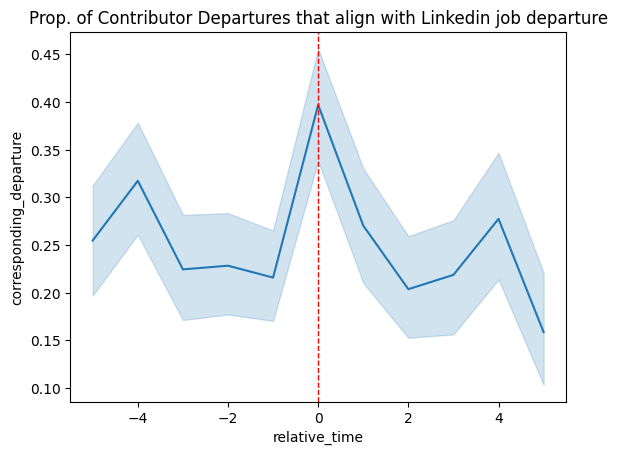

In [147]:
def pairwise(lst):
    return [[lst[i], lst[i+1]] for i in range(len(lst) - 1)]
def PlotDepartureEventStudy(df_departure_es, time_fe, individual_fe, pre_period, post_period):
    df_departure_es['corresponding_departure_og'] = df_departure_es['corresponding_departure']
    title_supp = ''
    if time_fe:
        df_departure_es['corresponding_departure'] = df_departure_es['corresponding_departure']-df_departure_es.groupby('time_period')['corresponding_departure'].transform('mean')
        title_supp = title_supp+ "\nTime FE"
    if individual_fe:
        df_departure_es['corresponding_departure'] = df_departure_es['corresponding_departure']-df_departure_es.groupby(['repo_name','actor_id'])['corresponding_departure'].transform('mean')
        title_supp = title_supp+'\nIndividual FE'
    if individual_fe and time_fe:
        df_departure_es['corresponding_departure'] = df_departure_es['corresponding_departure'] + df_departure_es['corresponding_departure_og']
    sns.lineplot(x='relative_time', y='corresponding_departure', data=df_departure_es.query(f'relative_time >= -{pre_period} & relative_time <= {post_period}').reset_index(), errorbar=('ci', 95))
    plt.axvline(x=0, color='red', linestyle='--', linewidth=1)
    plt.title(f'Prop. of Contributor Departures that align with Linkedin job departure' + title_supp)
    plt.savefig('issue/departure_linkedin_event_study.png')
    plt.show()

all_timerange_groups = np.sort(df_departure_range['time_range'].explode().unique())
pairwise_groups = pairwise(all_timerange_groups)
df_departure_es = df_departure_range.query('~startdate.isna()')
df_departure_es['all_timerange_groups'] = [pairwise_groups for i in range(df_departure_es.shape[0])]
df_departure_es = df_departure_es.explode('all_timerange_groups')

df_departure_es['startdate_dep'] = df_departure_es.apply(
    lambda x: any([x['all_timerange_groups'][0] <= ele <= x['all_timerange_groups'][1] for ele in x['startdate']]) if type(x['startdate']) == list else False, axis = 1)
df_departure_es['enddate_dep'] = df_departure_es.apply(
    lambda x: any([x['all_timerange_groups'][0] <= ele <= x['all_timerange_groups'][1] for ele in x['enddate']]) if type(x['enddate']) == list else False, axis = 1)
df_departure_es['corresponding_departure'] = df_departure_es.apply(
    lambda x: x['startdate_dep'] or x['enddate_dep'], axis = 1)

df_departure_es['departure_date'] = df_departure_es.apply(lambda x: x['time_range'][0] == x['all_timerange_groups'][0], axis = 1)
df_departure_es['time_period'] = df_departure_es['time_range'].apply(lambda x: x[0])
df_departure_es.sort_values(['actor_id','time_period'])
df_departure_es['relative_time'] = df_departure_es.groupby('actor_id')['time_period'].cumcount()
departure_time = df_departure_es.query('departure_date == True')[['repo_name','actor_id','relative_time']].rename({'relative_time':'treatment_time'}, axis = 1)
df_departure_es = pd.merge(df_departure_es, departure_time, how = 'left')
df_departure_es['relative_time'] = df_departure_es['relative_time']-df_departure_es['treatment_time']
PlotDepartureEventStudy(df_departure_es, False, False, 5, 5)